In [67]:
import os
import time
from glob import glob

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from sklearn import (
    metrics,  # Import scikit-learn metrics module for accuracy calculation
)
from sklearn import tree
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from tqdm.notebook import tqdm

%matplotlib widget

# Paths

In [90]:
tables = "/arc/home/heestersnick/dwarforge/tables"
models = "/arc/home/heestersnick/dwarforge/models"
data_dir = "/arc/projects/unions/ssl/data/raw/tiles/dwarforge"
training_data_file = "umap_data_master.parquet"
if training_data_file.endswith(".csv"):
    training_data = pd.read_csv(os.path.join(tables, training_data_file))
elif training_data_file.endswith(".parquet"):
    training_data = pd.read_parquet(os.path.join(tables, training_data_file))
    training_data["lsb_cfis_lsb-r"] = training_data["lsb_cfis_lsb-r"].fillna(0)
    training_data.rename(columns={"lsb_cfis_lsb-r": "lsb"}, inplace=True)
    training_data.drop(columns=["lsb_whigs-g"], inplace=True)
    training_data.drop(columns=["lsb_ps-i"], inplace=True)

# Functions

In [95]:
def plot_confusion_matrix(
    y_true, y_pred, labels, title="Confusion Matrix", cmap="viridis"
):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    gs = plt.GridSpec(
        len(labels), len(labels) + 1, width_ratios=[4] * len(labels) + [0.1]
    )
    plt.figure(figsize=(len(labels) + 3, len(labels) + 3))
    ax = sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        cbar_kws={"shrink": 0.805},
        square=True,
        xticklabels=labels,
        yticklabels=labels,
    )

    for i in range(len(labels)):
        for j in range(len(labels)):
            if i == j:
                ax.text(
                    j + 0.5,
                    i + 0.5,
                    f"{cm[i, j]:d}\n{cm_percentage[i, j]:.1f}%",
                    ha="center",
                    va="center",
                    fontsize=10,
                    color="black",
                )
            else:
                ax.text(
                    j + 0.5,
                    i + 0.5,
                    f"{cm[i, j]:d}\n{cm_percentage[i, j]:.1f}%",
                    ha="center",
                    va="center",
                    fontsize=10,
                    color="white",
                )

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    # plt.savefig('/home/nick/Documents/Candidacy_Exam/Presentation/Figures/'+'cm_w_percentage.png', bbox_inches='tight', dpi=300)
    plt.show()


def classify_and_save_parquet(
    parent_folder, random_forest_model, features, df_path_out, band="cfis_lsb-r"
):
    pattern = os.path.join(
        parent_folder, "*_*", band, "CFIS_LSB.*.r_rebin_det_params.parquet"
    )
    positive_class_rows = []
    for file in tqdm(glob(pattern)):
        try:
            filename = os.path.basename(file)
            tile_numbers = filename.split(".")[1:3]
            tile_id = f"({tile_numbers[0]}, {tile_numbers[1]})"

            # Read the parquet file
            df = pd.read_parquet(file)

            # Select only the columns used for inference
            X = df[features]

            # Apply the random forest model
            df["class"] = random_forest_model.predict(X)

            # Aggregate rows where class = 1
            positive_rows = df[df["class"] == 1].copy()
            positive_rows["tile"] = tile_id  # Add file path for reference
            positive_class_rows.append(positive_rows)

            # Save the updated dataframe back to parquet
            df.to_parquet(file, index=False)

        except Exception as e:
            print(f"Error processing file {file}: {str(e)}")
            continue

    # Combine all positive class rows into a single DataFrame
    if positive_class_rows:
        all_positive_rows = pd.concat(positive_class_rows, ignore_index=True)
        all_positive_rows.to_parquet(df_path_out, index=False)
    else:
        all_positive_rows = pd.DataFrame()

    return all_positive_rows


def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Additional metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    balanced_accuracy = (recall + specificity) / 2

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Average Precision (AP) summarizes a precision-recall curve
    average_precision = average_precision_score(y_test, y_pred_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")

    plot_confusion_matrix(y_test, y_pred, labels=["no dwarf", "dwarf"])

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.2, color="b")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Precision-Recall curve: AP={average_precision:0.2f}")
    plt.show()

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve")
    plt.show()


def sample_and_shuffle_data(df, label_column="lsb", neg_pos_ratio=3, random_state=42):
    # Separate positive and negative examples
    positive_df = df[df[label_column] == 1]
    negative_df = df[df[label_column] == 0]

    # Calculate the number of negative examples to keep
    n_positive = len(positive_df)
    n_negative_to_keep = n_positive * neg_pos_ratio

    # Sample negative examples
    if len(negative_df) > n_negative_to_keep:
        negative_sample = negative_df.sample(
            n=int(n_negative_to_keep), random_state=random_state
        )
    else:
        negative_sample = negative_df  # Keep all if we don't have enough

    # Combine positive examples with sampled negative examples
    combined_df = pd.concat([positive_df, negative_sample])

    # Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    return shuffled_df

# Random Forest

In [164]:
# features = ['total_flux', 'mu_max', 'mu_median', 'mu_mean', 'n_pix', 're_arcsec', 'r_fwhm_arcsec', 'r_10_arcsec', 'r_25_arcsec', 'r_75_arcsec', 'r_90_arcsec', 'r_100_arcsec', 'A_arcsec', 'B_arcsec', 'axis_ratio', 'mag', 'mu', 'lsb']
features = [
    #"total_flux_cfis_lsb-r",
    #"mu_max_cfis_lsb-r",
    #"mu_median_cfis_lsb-r",
    #"mu_mean_cfis_lsb-r",
    "re_arcsec_cfis_lsb-r",
    #"r_fwhm_arcsec_cfis_lsb-r",
    "r_10_arcsec_cfis_lsb-r",
    "r_25_arcsec_cfis_lsb-r",
    #"r_75_arcsec_cfis_lsb-r",
    # "r_90_arcsec_cfis_lsb-r",
    "r_100_arcsec_cfis_lsb-r",
    #"axis_ratio_cfis_lsb-r",
    #"mag_cfis_lsb-r",
    #"mu_cfis_lsb-r",
    #"total_flux_whigs-g",
    # "mu_max_whigs-g",
    # "mu_median_whigs-g",
    # "mu_mean_whigs-g",
    "re_arcsec_whigs-g",
    # "r_fwhm_arcsec_whigs-g",
    "r_10_arcsec_whigs-g",
    "r_25_arcsec_whigs-g",
    #"r_75_arcsec_whigs-g",
    # "r_90_arcsec_whigs-g",
    "r_100_arcsec_whigs-g",
    # "axis_ratio_whigs-g",
    #"mag_whigs-g",
    #"mu_whigs-g",
    #"total_flux_ps-i",
    # "mu_max_ps-i",
    # "mu_median_ps-i",
    # "mu_mean_ps-i",
    "re_arcsec_ps-i",
    # "r_fwhm_arcsec_ps-i",
    "r_10_arcsec_ps-i",
    "r_25_arcsec_ps-i",
    #"r_75_arcsec_ps-i",
    # "r_90_arcsec_ps-i",
    "r_100_arcsec_ps-i",
    # "axis_ratio_ps-i",
    #"mag_ps-i",
    #"mu_ps-i",
    "lsb",
]
dwarf_column = "lsb"
training_df = training_data[features]
training_df = sample_and_shuffle_data(training_df, neg_pos_ratio=2.0)
X, y = training_df.drop(columns=[dwarf_column]), training_df[dwarf_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=np.random.randint(99)
)
print(
    f"Using {len(training_df)} examples. {np.count_nonzero(y == 1)} positive and {np.count_nonzero(y==0)} negative ones."
)
print(f"{len(X_train)} are used for training, {len(X_test)} for testing.")

Using 3138 examples. 1046 positive and 2092 negative ones.
2510 are used for training, 628 for testing.


In [165]:
# # Create the Random Forest classifier
# rf_classifier = RandomForestClassifier(
#     n_estimators=1000, random_state=np.random.randint(98)
# )
# # Train the classifier
# start_time = time.time()
# rf_classifier.fit(X_train, y_train)
# print("Training done! Finished in {} minutes.".format((time.time() - start_time) / 60))
# # Make predictions on the test set
# y_pred = rf_classifier.predict(X_test)

# Evaluate the model

In [166]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")

# Grid search for hyperparameters

In [173]:
class_weights = {0: 1, 1: 2}

param_grid = {
    "n_estimators": np.arange(50, 200, 15),
    "max_features": np.arange(0.1, 1, 0.1),
    "max_depth": [3, 5, 7, 9, 12],
    "max_samples": np.arange(0.2, 1, 0.2),
    "class_weight": [class_weights, "balanced", "balanced_subsample", None],
}

model = RSCV(RandomForestClassifier(), param_grid, n_iter=30, cv=5, scoring="f1").fit(
    X_train, y_train
)
model = model.best_estimator_

In [174]:
model

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=7, max_features=0.9,
                       max_samples=0.6000000000000001, n_estimators=170)

# Model evaluation

Accuracy: 0.9124
Precision: 0.8230
Recall (Sensitivity): 0.9434
Specificity: 0.8966
F1 Score: 0.8791
Balanced Accuracy: 0.9200
ROC AUC: 0.9743
Average Precision: 0.9473


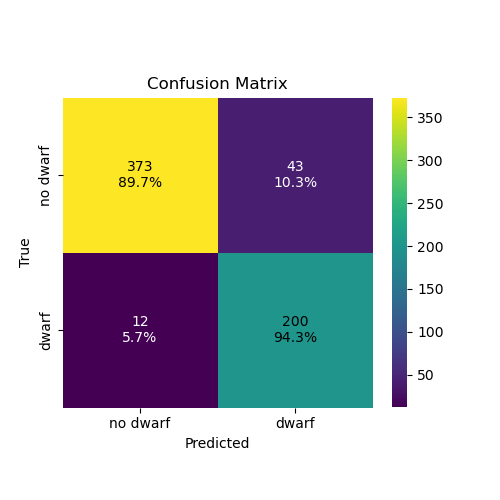

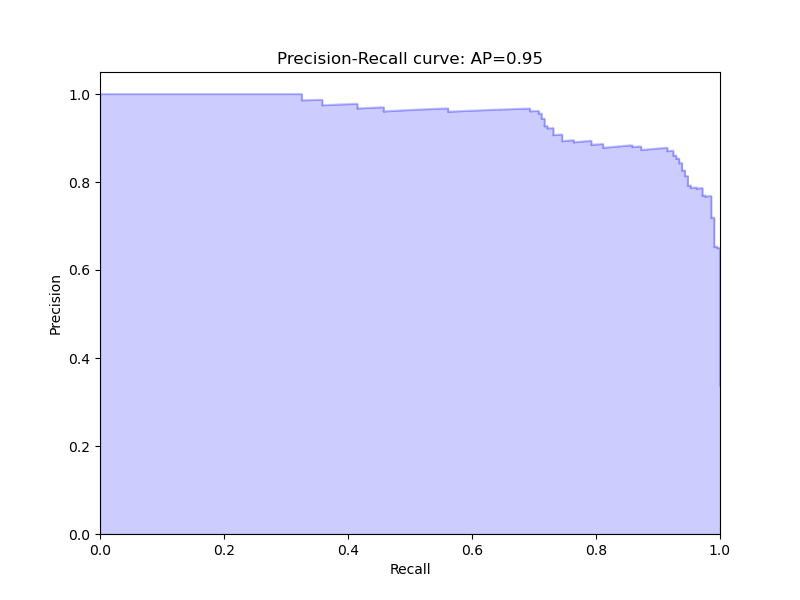

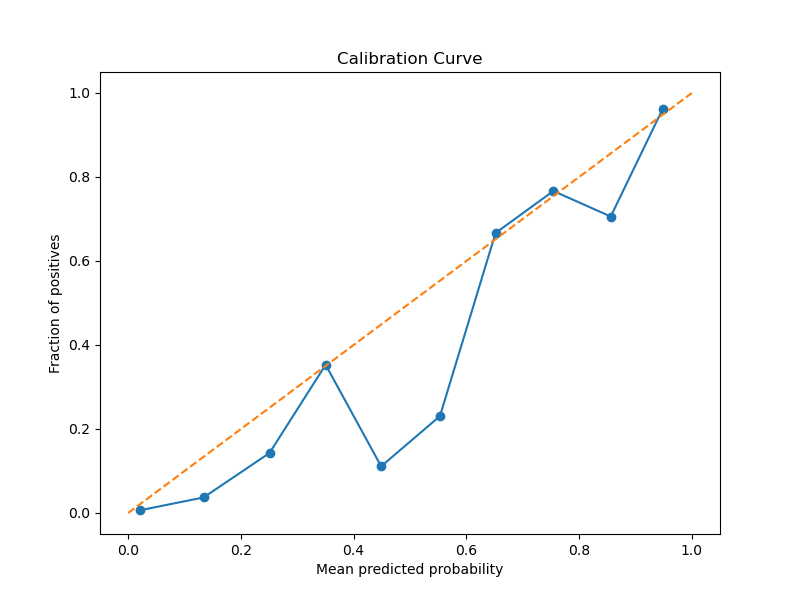

In [175]:
evaluate_model(model, X_test, y_test)

# Feature importance

In [176]:
model.fit(X_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_importance_df = pd.DataFrame(
    {
        "Feature": list(X_train.columns),
        "Importance": (importances / np.sum(importances)),
    }
)

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
).reset_index(drop=True)
feature_importance_df

,Feature,Importance
0,r_25_arcsec_cfis_lsb-r,0.515876
1,r_10_arcsec_cfis_lsb-r,0.167484
2,r_25_arcsec_whigs-g,0.052369
3,r_100_arcsec_cfis_lsb-r,0.045107
4,r_100_arcsec_whigs-g,0.041073
5,r_100_arcsec_ps-i,0.039318
6,r_10_arcsec_whigs-g,0.033807
7,re_arcsec_whigs-g,0.028556
8,re_arcsec_cfis_lsb-r,0.023873
9,re_arcsec_ps-i,0.021734


# Confusion matrix

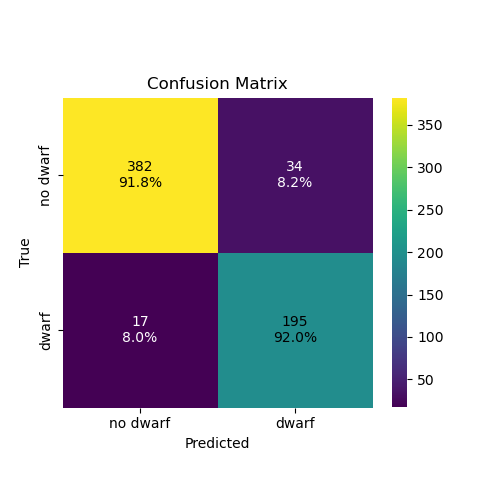

In [171]:
plt.close("all")
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels=["no dwarf", "dwarf"])

# Save the Model

In [91]:
# Save the model to a file
joblib.dump(model, os.path.join(models, "random_forest_model_4x_None.pkl"))

['/arc/home/heestersnick/dwarforge/models/random_forest_model_4x_None.pkl']

# Load the Model

In [5]:
loaded_model = joblib.load(os.path.join(models, "random_forest_model_1033.pkl"))

# Apply the Model to the Data

In [109]:
pos_class_df_path = os.path.join(tables, "pos_class.parquet")
# classify_and_save_parquet(data_dir, loaded_model, features=features, df_path_out=pos_class_df_path, band='cfis_lsb-r')

In [110]:
pos_class = pd.read_parquet(pos_class_df_path)

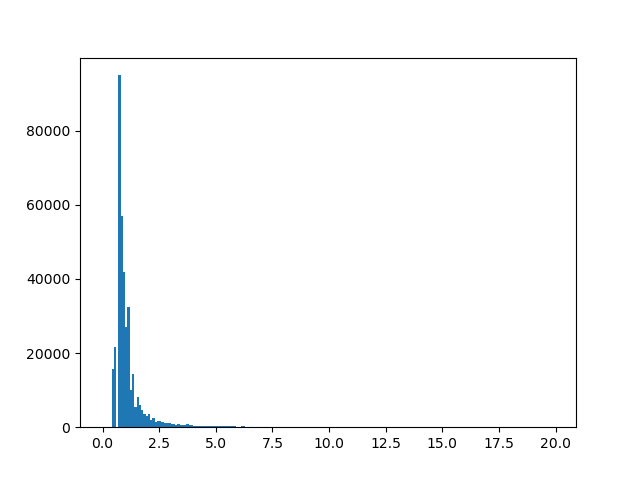

In [41]:
plt.figure()
bins = np.arange(0.001, 20, 0.1)
plt.hist(pos_class.r_10_arcsec.values, bins=bins)
plt.show()

In [42]:
dwarfs = training_data[training_data["lsb"] == 1].reset_index(drop=True)

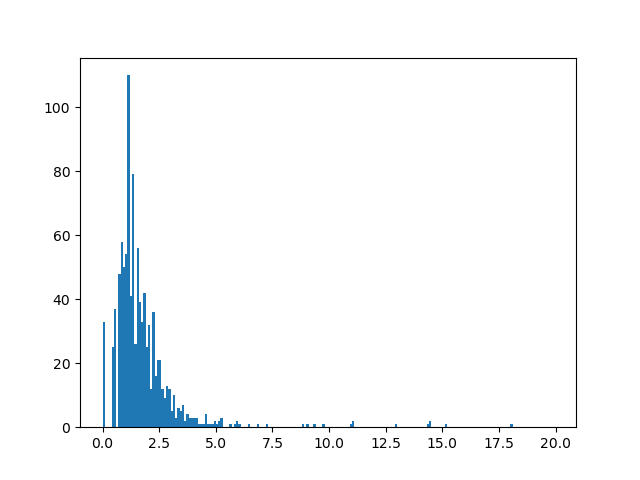

In [44]:
plt.figure()
bins = np.arange(0, 20, 0.1)
plt.hist(dwarfs.r_10_arcsec.values, bins=bins)
plt.show()

In [46]:
np.count_nonzero(dwarfs["r_10_arcsec"].values == 0.0)

33

In [54]:
np.count_nonzero(dwarfs["r_10_arcsec"].values > 0.4)

1000

In [114]:
np.count_nonzero(pos_class["re_arcsec"].values <= 1.6)

961

In [107]:
pos_class

NameError: name 'pos_class' is not defined